In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib import models, graph, coarsening
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from data_utils import *

In [7]:
N_COEF = 8

In [8]:
X = np.load('/Users/linggeli/cnn_graph/fmri/clas_data/X_259sub_40reg_16coef.npy')
X = X[:, :, :N_COEF]
y = np.load('/Users/linggeli/cnn_graph/fmri/clas_data/y_259sub.npy')

In [9]:
print(X.shape)
print(y.shape)

(1036, 40, 8)
(1036,)


In [10]:
n_train = 700
n_val =  300

np.random.seed(0)
indices = np.random.permutation(X.shape[0])

X_train = X[indices[:n_train]]
X_val   = X[indices[n_train:n_train+n_val]]

y_train = y[indices[:n_train]]
y_val   = y[indices[n_train:n_train+n_val]]

In [11]:
X_train = (X_train - np.mean(X)) / np.std(X)
X_val = (X_val - np.mean(X)) / np.std(X)

In [12]:
from scipy import sparse

In [14]:
adj_matrix = np.genfromtxt('/Users/linggeli/cnn_graph/fmri/clas_data/adj_matrix.csv', delimiter=',')
adj_matrix[np.isnan(adj_matrix)] = 0
print(adj_matrix.shape)

(375, 375)


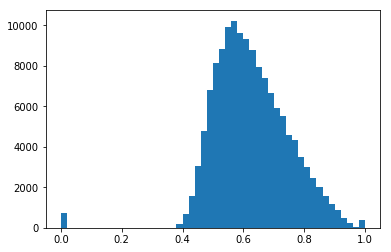

In [15]:
plt.hist(adj_matrix.flatten(), bins=50)
plt.show()

In [16]:
THRES = 0.7

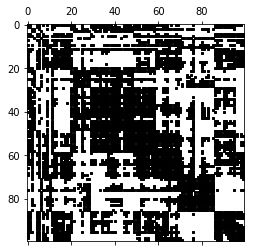

In [17]:
A = adj_matrix.copy()
A = A[:100, :100]
A[A < THRES] = 0
A = sparse.csr_matrix(A).astype(np.float32)
plt.spy(A, markersize=2, color='black')
plt.show()

In [18]:
graphs, perm = coarsening.coarsen(A, levels=3, self_connections=False)

Layer 0: M_0 = |V| = 104 nodes (4 added),|E| = 2455 edges
Layer 1: M_1 = |V| = 52 nodes (2 added),|E| = 913 edges
Layer 2: M_2 = |V| = 26 nodes (1 added),|E| = 257 edges
Layer 3: M_3 = |V| = 13 nodes (0 added),|E| = 75 edges


In [19]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

In [20]:
X_train_list = []
X_val_list = []
for i in range(N_COEF):
    X_train_list.append(coarsening.perm_data(X_train[:, :, i], perm))
    X_val_list.append(coarsening.perm_data(X_val[:, :, i], perm))

X_train_perm = np.stack(X_train_list, axis=-1)
X_val_perm = np.stack(X_val_list, axis=-1)

In [21]:
from fmri.graph_models import multi_cgcnn

In [22]:
N_FILTER = 30
DENSE_SIZE = 20

In [23]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 50
params['batch_size']     = 20
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [N_FILTER, N_FILTER]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [DENSE_SIZE, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1.0
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

params['n_graph'] = N_COEF

In [24]:
model = multi_cgcnn(L, **params)

NN architecture
  input: M_0 = 104
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 104 * 30 / 4 = 780
    weights: F_0 * F_1 * K_1 = 1 * 30 * 10 = 300
    biases: F_1 = 30
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 26 * 30 / 2 = 390
    weights: F_1 * F_2 * K_2 = 30 * 30 * 10 = 9000
    biases: F_2 = 30
  layer 3: fc1
    representation: M_3 = 20
    weights: M_2 * M_3 = 390 * 20 = 7800
    biases: M_3 = 20
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 20 * 2 = 40
    biases: M_4 = 2


In [25]:
accuracy, loss, t_step = model.fit(X_train_perm, y_train, X_val_perm, y_val)

step 100 / 1750 (epoch 2.86 / 50):
  learning_rate = 9.03e-04, loss_average = 8.09e-01
  validation accuracy: 59.00 (177 / 300), f1 (weighted): 58.37, loss: 8.06e-01
  time: 33s (wall 12s)
step 200 / 1750 (epoch 5.71 / 50):
  learning_rate = 7.74e-04, loss_average = 8.02e-01
  validation accuracy: 58.67 (176 / 300), f1 (weighted): 53.91, loss: 8.03e-01
  time: 64s (wall 23s)
step 300 / 1750 (epoch 8.57 / 50):
  learning_rate = 6.63e-04, loss_average = 8.08e-01
  validation accuracy: 58.67 (176 / 300), f1 (weighted): 56.84, loss: 8.02e-01
  time: 93s (wall 31s)
step 400 / 1750 (epoch 11.43 / 50):
  learning_rate = 5.69e-04, loss_average = 8.11e-01
  validation accuracy: 58.67 (176 / 300), f1 (weighted): 55.70, loss: 8.02e-01
  time: 122s (wall 39s)
step 500 / 1750 (epoch 14.29 / 50):
  learning_rate = 4.88e-04, loss_average = 7.99e-01
  validation accuracy: 58.67 (176 / 300), f1 (weighted): 56.71, loss: 7.99e-01
  time: 153s (wall 49s)
step 600 / 1750 (epoch 17.14 / 50):
  learning_rate